In [1]:
#Modelo distilBERT

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import torch.optim
import numpy as np
import pandas as pd
import time
import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
from textwrap import wrap
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
import re,string
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from string import punctuation
from nltk.corpus import wordnet


MAX_LEN = 128

# Select cpu or cuda
run_on = 'cpu'
device = torch.device(run_on)

df_train = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/60-20-20/train.csv')
print(df_train.shape)
df_train.isnull().sum()
df_train.sentiment.replace("P" , 2 , inplace = True)
df_train.sentiment.replace("N" , 0 , inplace = True)
df_train.sentiment.replace("NEU" , 1, inplace = True)
df_train.head()
df_train['review'] = df_train['text']
df_train.drop('text', axis=1, inplace=True)
df_train['label'] = df_train['sentiment']
df_train.drop('sentiment', axis=1, inplace=True)

df_dev = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/60-20-20/dev.csv')
print(df_dev.shape)
df_dev.isnull().sum()
df_dev.sentiment.replace("P" , 2 , inplace = True)
df_dev.sentiment.replace("N" , 0 , inplace = True)
df_dev.sentiment.replace("NEU" , 1, inplace = True)
df_dev['review'] = df_dev['text']
df_dev.drop('text', axis=1, inplace=True)
df_dev['label'] = df_dev['sentiment']
df_dev.drop('sentiment', axis=1, inplace=True)

df_test = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/60-20-20/test.csv')
print(df_dev.shape)
df_test.isnull().sum()
df_test.sentiment.replace("P" , 2 , inplace = True)
df_test.sentiment.replace("N" , 0 , inplace = True)
df_test.sentiment.replace("NEU" , 1, inplace = True)
df_test['review'] = df_test['text']
df_test.drop('text', axis=1, inplace=True)
df_test['label'] = df_test['sentiment']
df_test.drop('sentiment', axis=1, inplace=True)



/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-01 00:05:19.971747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(4340, 2)
(1447, 2)
(1447, 2)


In [2]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS


#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [3]:
print(df_train)

                                                 review  label
0     @Jorge_LBU Espero que te mejores pronto, vomit...      0
1     @ClubPaniniMx @PaniniComicsMx genial espero qu...      1
2                     kali uchis va a estar en bahidorá      1
3     @ferdiazgil @FranDguez sí, lo he leído ese tem...      0
4     @AbrahamMateoESP Exacto! Todo lo que él hace l...      1
...                                                 ...    ...
4335               tu en serio por que sois tan tontos       0
4336  Yo muchísimo mas . Hablamos al DM y te paso él...      1
4337  Les platicó algo bonito? Bueno pues, el último...      2
4338           Una breve reseña de quien soy realmente.      1
4339                   @MicaGiudice el tuyo quedo mejor      2

[4340 rows x 2 columns]


In [4]:
review_new_train = []
review_new_dev = []
review_new_test = []

for t in df_train.review:
    review_new_train.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

for t in df_dev.review:
    review_new_dev.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

for t in df_test.review:
    review_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

In [5]:
df_train['review'] = review_new_train
df_dev['review'] = review_new_dev
df_test['review'] = review_new_test

In [100]:
print(df_train.head(1))
print(df_dev.head(1))
print(df_test.head(1))

                                              review  label
0  espero que te mejores pronto vomitar es muy de...      0
                                              review  label
0  ola wapa k tal stas spero k no seas una sorra ...      0
                                              review  label
0  amigos deseo establecer contacto con uds agrad...      1


In [101]:
X_train = df_train.iloc[:, 0]
y_train = df_train.iloc[:, 1]
X_dev = df_dev.iloc[:, 0]
y_dev = df_dev.iloc[:, 1]

In [102]:
# Tokenization

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',
            do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []
    for doc in dataset:
        encoded_doc = tokenizer.encode_plus(doc,
                   add_special_tokens=True, max_length=MAX_LEN,
                   truncation=True ,pad_to_max_length=True,
                   return_token_type_ids = False,
                   return_attention_mask = True,)
        input_ids.append(encoded_doc['input_ids'])
        attention_mask.append(encoded_doc['attention_mask'])
    return (torch.tensor(input_ids),
           torch.tensor(attention_mask))

# Apply preprocessing to dataset
X_train_inputs, X_train_masks = preprocessing(X_train)
X_dev_inputs, X_dev_masks = preprocessing(X_dev)

# Report max n° tokens in a sentence
max_len = max([torch.sum(sen) for sen in X_train_masks])
print('Max n°tokens in a sentence: {0}'.format(max_len))

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Max n°tokens in a sentence: 54


In [103]:
#Data loaders
batch_size = 8

y_train_labels = torch.tensor(y_train.values)
y_dev_labels = torch.tensor(y_dev.values)

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size, num_workers=4)
    
    return dataloader

train_dataloader = dataloader(X_train_inputs, X_train_masks, y_train_labels)
val_dataloader = dataloader(X_dev_inputs, X_dev_masks, y_dev_labels)

In [104]:
#Cargamos el modelo + optimizador + definimos EPOCHS + Scheduler
#Modelo
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3,
 output_attentions=False, output_hidden_states=False)

optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-6)

epochs=4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps= total_steps)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

In [105]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [106]:
#Definimos una funcion para formatear el tiempo y otra para calcular la exactitud
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

======= Epoch 1 / 4 =======
======= Epoch 2 / 4 =======
======= Epoch 3 / 4 =======
======= Epoch 4 / 4 =======


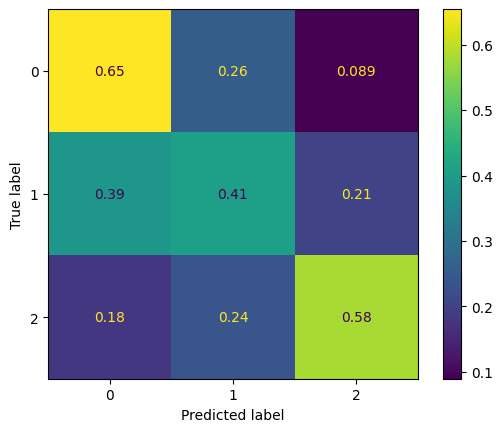

              precision    recall  f1-score   support

           1       0.62      0.65      0.63      2396
           2       0.42      0.41      0.41      1760
           3       0.62      0.58      0.60      1632

    accuracy                           0.56      5788
   macro avg       0.55      0.55      0.55      5788
weighted avg       0.56      0.56      0.56      5788

f1 score macro: 0.549233062774416


In [108]:
#Definimos la funcion para entrenar el modelo y entregar los resultados en el set de validación
#Train model
all_logits = []
all_labels = []
avg_train_loss = []

def training(n_epochs, training_dataloader, validation_dataloader):
    for epoch_i in range(0, n_epochs):
        print('======= Epoch {:} / {:} ======='.format(epoch_i + 1, epochs))
        # Mira cuanto tiempo le cuesta entrenar un EPOCH.
        t0 = time.time()
        # Resetea la perdida para este EPOCH.
        total_loss = 0
        # Pone el modelo en modo entrenamiento.
        model.train()
        # Para cada batch en el training data
        for step, batch in enumerate(training_dataloader):
            batch_loss = 0
            # Unpack this training batch from dataloader
            #   [0]: input ids, [1]: attention masks, 
            #   [2]: labels
            b_input_ids,b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)

            # Limpia el gradiente calculado anteriormente
            model.zero_grad()

            # Genera un paso adelante
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            # Saca el loss value fuera del output
            loss = outputs[0]
            batch_loss += loss.item()
            total_loss += loss.item()

            # Genera un paso atras
            loss.backward()

            # Clipea el los gradientes a 1.0.
            torch.nn.utils.clip_grad_norm_(model.parameters(),
                                            1.0)

            # Actualiza los parametros
            # ¿take a step using the computed gradient?
            optimizer.step()
            scheduler.step()

        # Calcula el average loss sobre el training data.
        avg_train_loss = total_loss / len(train_dataloader)

        #Validación
        # Despues de completar un entrenamiento genera un paso de validacion


        t0 = time.time()

        # Pone el modelo en modo evaluación
        model.eval()

        # Trackea las variables
        eval_loss, eval_accuracy = 0, 0

        # Evalua el data para un epoch mas
        for step, batch in enumerate(validation_dataloader):
            # Add batch to device
            # Unpack this training batch from our dataloader.
            #   [0]: input ids, [1]: attention masks,
            #   [2]: labels
            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)


            # El modelo no computa los gradientes
            with torch.no_grad():
                # Paso adelante 
                # Devolvemos los loggits 
                outputs = model(b_input_ids,
                                attention_mask=b_input_mask)

            # Los "logits" son el valor de salida
            logits = outputs[0]

            # Mueve los logits y labels a la CPU
            logits = logits.detach().cpu().numpy()
            b_labels = b_labels.to('cpu').numpy()

            # Guarda los logits y labels del batch
            # Utilizamos esto en la matriz de confusión
            predict_labels = np.argmax(logits, axis=1).flatten()
            all_logits.extend(predict_labels.tolist())
            all_labels.extend(b_labels.tolist())

            # Calcula la precision para este batch
            tmp_eval_accuracy = flat_accuracy(logits, b_labels)
            # Accumula la precisión total
            eval_accuracy += tmp_eval_accuracy
    
    #Print la matriz de confussión"
    conf = confusion_matrix(all_labels, all_logits, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    disp.plot()
    plt.show()

    target_names = ['1', '2', '3']
    print(classification_report(all_labels, all_logits, target_names=target_names))
    print("f1 score macro:", f1_score(all_labels, all_logits, average='macro'))




#Llamamos a la funcion para entrenar el modelo
training(epochs, train_dataloader, val_dataloader)

In [15]:
#Guardamos el modelo
model.save_pretrained('/Volumes/NFANLO/TFG/DistilBert/model')

tokenizer.save_pretrained('/Volumes/NFANLO/TFG/DistilBert/tokenizer')

('/Volumes/NFANLO/TFG/DistilBert/tokenizer/tokenizer_config.json',
 '/Volumes/NFANLO/TFG/DistilBert/tokenizer/special_tokens_map.json',
 '/Volumes/NFANLO/TFG/DistilBert/tokenizer/vocab.txt',
 '/Volumes/NFANLO/TFG/DistilBert/tokenizer/added_tokens.json')

In [7]:
X_test = df_dev.iloc[:, 0]
y_test = df_dev.iloc[:, 1]

In [16]:
# Tokenization

tokenizer = DistilBertTokenizer.from_pretrained('/Volumes/NFANLO/TFG/DistilBert/tokenizer',
            do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []
    for doc in dataset:
        encoded_doc = tokenizer.encode_plus(doc,
                   add_special_tokens=True, max_length=MAX_LEN,
                   truncation=True ,pad_to_max_length=True,
                   return_token_type_ids = False,
                   return_attention_mask = True,)
        input_ids.append(encoded_doc['input_ids'])
        attention_mask.append(encoded_doc['attention_mask'])
    return (torch.tensor(input_ids),
           torch.tensor(attention_mask))

# Apply preprocessing to dataset
X_test_inputs, X_test_masks = preprocessing(X_test)

# Report max n° tokens in a sentence
max_len = max([torch.sum(sen) for sen in X_test_masks])
print('Max n°tokens in a sentence: {0}'.format(max_len))

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Max n°tokens in a sentence: 53


In [17]:
#Data loaders
batch_size = 8

y_test_labels = torch.tensor(y_test.values)

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size, num_workers=4)
    
    return dataloader

test_dataloader = dataloader(X_test_inputs, X_test_masks, y_test_labels)

In [18]:
#Cargamos el modelo + optimizador + definimos EPOCHS + Scheduler
#Modelo
model = DistilBertForSequenceClassification.from_pretrained('/Volumes/NFANLO/TFG/DistilBert/model', num_labels=3,
 output_attentions=False, output_hidden_states=False)

optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-6)

epochs=4

total_steps = len(test_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps= total_steps)

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [20]:
#Definimos una funcion para formatear el tiempo y otra para calcular la exactitud
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

======= Epoch 1 / 4 =======
======= Epoch 2 / 4 =======
======= Epoch 3 / 4 =======
======= Epoch 4 / 4 =======


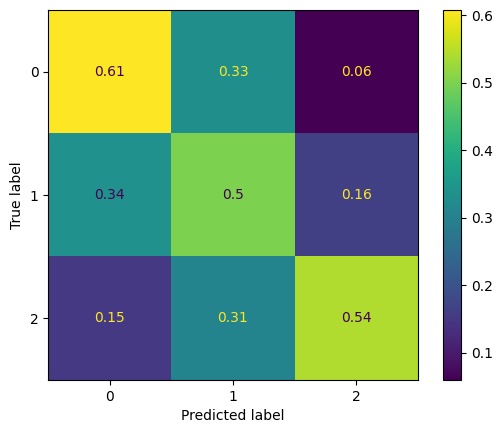

              precision    recall  f1-score   support

           1       0.63      0.61      0.62      2396
           2       0.40      0.50      0.45      1760
           3       0.67      0.54      0.60      1632

    accuracy                           0.56      5788
   macro avg       0.57      0.55      0.56      5788
weighted avg       0.57      0.56      0.56      5788

f1 score macro: 0.5558379873880531
accuracy score: 0.5563234277816171


In [21]:
#Definimos la funcion para pasar el test por el modelo y entregar los resultados
all_logits_test = []
all_labels_test = []
avg_train_loss_test = []

def training(n_epochs, test_dataloader):
    for epoch_i in range(0, n_epochs):
        print('======= Epoch {:} / {:} ======='.format(epoch_i + 1, epochs))
        # Pone el modelo en modo evaluación
        model.eval()

        # Trackea las variables
        eval_loss, eval_accuracy = 0, 0

        # Evalua el data para un epoch mas
        for step, batch in enumerate(test_dataloader):
            # Add batch to device
            # Unpack this training batch from our dataloader.
            #   [0]: input ids, [1]: attention masks,
            #   [2]: labels
            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)


            # El modelo no computa los gradientes
            with torch.no_grad():
                # Paso adelante 
                # Devolvemos los loggits 
                outputs = model(b_input_ids,
                                attention_mask=b_input_mask)

            # Los "logits" son el valor de salida
            logits = outputs[0]

            # Mueve los logits y labels a la CPU
            logits = logits.detach().cpu().numpy()
            b_labels = b_labels.to('cpu').numpy()

            # Guarda los logits y labels del batch
            # Utilizamos esto en la matriz de confusión
            predict_labels = np.argmax(logits, axis=1).flatten()
            all_logits_test.extend(predict_labels.tolist())
            all_labels_test.extend(b_labels.tolist())

            # Calcula la precision para este batch
            tmp_eval_accuracy = flat_accuracy(logits, b_labels)
            # Accumula la precisión total
            eval_accuracy += tmp_eval_accuracy
    
    #Print la matriz de confussión"
    conf = confusion_matrix(all_labels_test, all_logits_test, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    disp.plot()
    plt.show()
  
    target_names = ['1', '2', '3']
    print(classification_report(all_labels_test, all_logits_test, target_names=target_names))
    print("f1 score macro:", f1_score(all_labels_test, all_logits_test, average='macro'))
    print("accuracy score:", accuracy_score(all_labels_test, all_logits_test))




#Llamamos a la funcion para entrenar el modelo
training(epochs, test_dataloader)        